In [1]:
import pyarrow.parquet as pq
import pandas as pd
import numpy as np
import pathlib
import warnings

from sklearn.utils import shuffle, parallel_backend
from sklearn.exceptions import ConvergenceWarning
from joblib import dump

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    StratifiedKFold,
    GridSearchCV,
)
from joblib import load
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import toml
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import ast

In [2]:
# Parameters
cell_type = "SHSY5Y"
aggregation = False
nomic = False
flag = True
control = "DMSO_0.100_DMSO_0.025"
treatment = "LPS_100.000_DMSO_0.025"

In [3]:
print(cell_type, aggregation, nomic, flag, control, treatment)

SHSY5Y False False True DMSO_0.100_DMSO_0.025 LPS_100.000_DMSO_0.025


In [4]:
if flag == False:
    # read in toml file and get parameters
    toml_path = pathlib.Path("../1.train_models/single_class_config.toml")
    with open(toml_path, "r") as f:
        config = toml.load(f)
    control = config["logistic_regression_params"]["control"]
    treatment = config["logistic_regression_params"]["treatments"]
    aggregation = ast.literal_eval(config["logistic_regression_params"]["aggregation"])
    nomic = ast.literal_eval(config["logistic_regression_params"]["nomic"])
    cell_type = config["logistic_regression_params"]["cell_type"]
    print(aggregation, nomic, cell_type)

In [5]:
if flag == False:
    # read in toml file and get parameters
    toml_path = pathlib.Path("../1.train_models/single_class_config.toml")
    with open(toml_path, "r") as f:
        config = toml.load(f)
    f.close()
    control = config["logistic_regression_params"]["control"]
    treatment = config["logistic_regression_params"]["treatments"]
    aggregation = ast.literal_eval(config["logistic_regression_params"]["aggregation"])
    nomic = ast.literal_eval(config["logistic_regression_params"]["nomic"])
    cell_type = config["logistic_regression_params"]["cell_type"]
    print(aggregation, nomic, cell_type)

In [6]:
# set path for figures
if (aggregation == True) and (nomic == True):
    figure_path = pathlib.Path(
        f"./figures/single_class/{cell_type}/aggregated_with_nomic/{control}__{treatment}"
    )
    results_path = pathlib.Path(
        f"./results/single_class/{cell_type}/aggregated_with_nomic/{control}__{treatment}"
    )
elif (aggregation == True) and (nomic == False):
    figure_path = pathlib.Path(
        f"./figures/single_class/{cell_type}/aggregated/{control}__{treatment}"
    )
    results_path = pathlib.Path(
        f"./results/single_class/{cell_type}/aggregated/{control}__{treatment}"
    )
elif (aggregation == False) and (nomic == True):
    figure_path = pathlib.Path(
        f"./figures/single_class/{cell_type}/sc_with_nomic/{control}__{treatment}"
    )
    results_path = pathlib.Path(
        f"./results/single_class/{cell_type}/sc_with_nomic/{control}__{treatment}"
    )
elif (aggregation == False) and (nomic == False):
    figure_path = pathlib.Path(
        f"./figures/single_class/{cell_type}/sc/{control}__{treatment}"
    )
    results_path = pathlib.Path(
        f"./results/single_class/{cell_type}/sc/{control}__{treatment}"
    )
else:
    print("Error")

In [7]:
# read in data
df = pd.read_csv(f"{results_path}/compiled_predictions.csv")

In [8]:
# set model path from parameters
if (aggregation == True) and (nomic == True):
    model_path = pathlib.Path(
        f"models/single_class/{cell_type}/aggregated_with_nomic/{control}__{treatment}"
    )
elif (aggregation == True) and (nomic == False):
    model_path = pathlib.Path(
        f"models/single_class/{cell_type}/aggregated/{control}__{treatment}"
    )
elif (aggregation == False) and (nomic == True):
    model_path = pathlib.Path(
        f"models/single_class/{cell_type}/sc_with_nomic/{control}__{treatment}"
    )
elif (aggregation == False) and (nomic == False):
    model_path = pathlib.Path(
        f"models/single_class/{cell_type}/sc/{control}__{treatment}"
    )
else:
    print("Error")

In [9]:
# set path for figures
if (aggregation == True) and (nomic == True):
    figure_path = pathlib.Path(
        f"./figures/single_class/{cell_type}/aggregated_with_nomic/{control}__{treatment}"
    )

elif (aggregation == True) and (nomic == False):
    figure_path = pathlib.Path(
        f"./figures/single_class/{cell_type}/aggregated/{control}__{treatment}"
    )

elif (aggregation == False) and (nomic == True):
    figure_path = pathlib.Path(
        f"./figures/single_class/{cell_type}/sc_with_nomic/{control}__{treatment}"
    )

elif (aggregation == False) and (nomic == False):
    figure_path = pathlib.Path(
        f"./figures/single_class/{cell_type}/sc/{control}__{treatment}"
    )

else:
    print("Error")
figure_path.mkdir(parents=True, exist_ok=True)

In [10]:
model_types = ["final", "shuffled_baseline"]
feature_types = ["CP"]
phenotypic_classes = [treatment]
evaluation_types = ["train", "test"]

final CP LPS_100.000_DMSO_0.025 train
LogisticRegression(C=0.001, class_weight='balanced', l1_ratio=0.9, max_iter=10,
                   n_jobs=-1, penalty='elasticnet', random_state=0,
                   solver='saga')


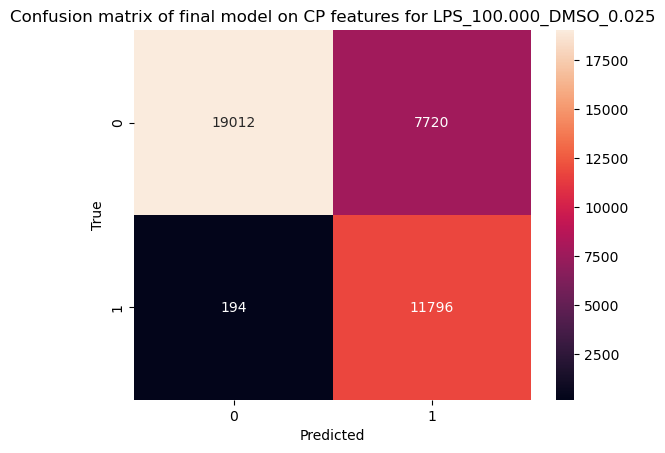

final CP LPS_100.000_DMSO_0.025 test
LogisticRegression(C=0.001, class_weight='balanced', l1_ratio=0.9, max_iter=10,
                   n_jobs=-1, penalty='elasticnet', random_state=0,
                   solver='saga')


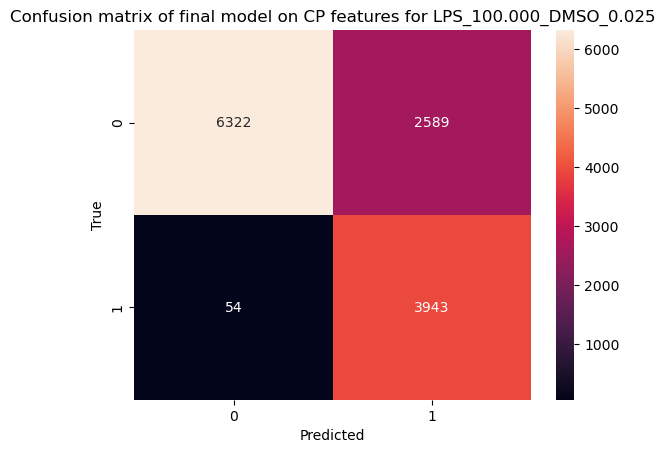

shuffled_baseline CP LPS_100.000_DMSO_0.025 train
LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=1.0, max_iter=10,
                   n_jobs=-1, penalty='elasticnet', random_state=0,
                   solver='saga')


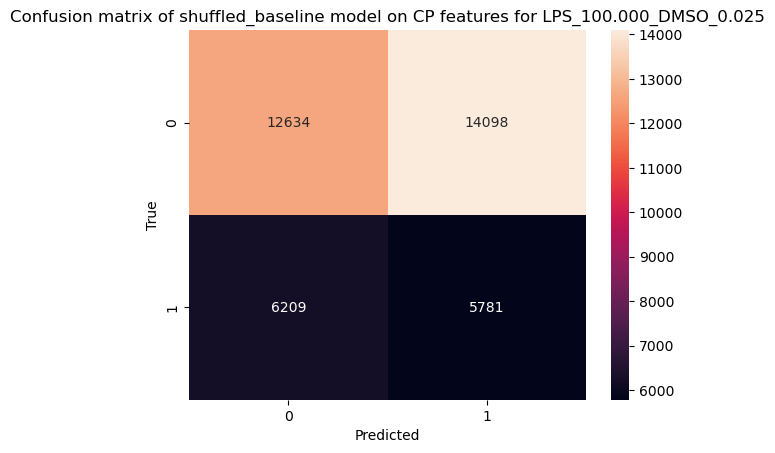

shuffled_baseline CP LPS_100.000_DMSO_0.025 test
LogisticRegression(C=0.01, class_weight='balanced', l1_ratio=1.0, max_iter=10,
                   n_jobs=-1, penalty='elasticnet', random_state=0,
                   solver='saga')


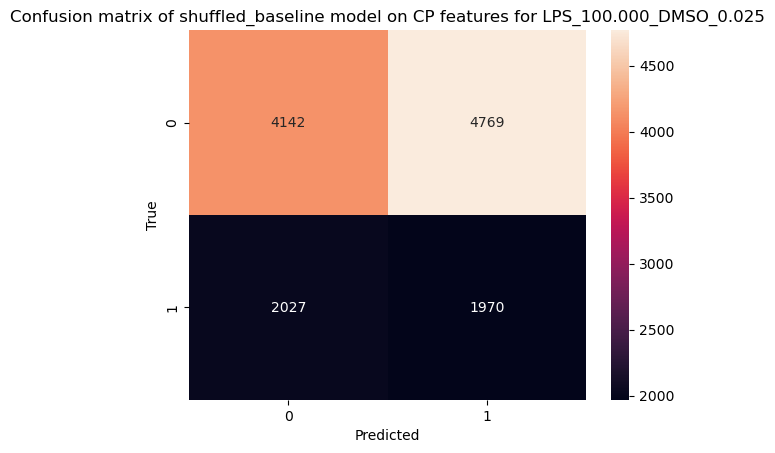

In [11]:
for model_type, feature_type, phenotypic_class, evaluation_type in itertools.product(
    model_types, feature_types, phenotypic_classes, evaluation_types
):
    print(model_type, feature_type, phenotypic_class, evaluation_type)
    # load model
    model = load(f"../1.train_models/{model_path}/{model_type}__{feature_type}.joblib")
    print(model)

    if evaluation_type == "train":
        # get data_split train
        df_train = df[df["data_split"] == "train"]

        if model_type == "final":
            df_train_final = df_train[df_train["shuffled"] == False]
            model = load(
                f"../1.train_models/{model_path}/{model_type}__{feature_type}.joblib"
            )

            sns.heatmap(
                confusion_matrix(
                    df_train_final["Phenotypic_Class_True"],
                    df_train_final["Phenotypic_Class_Predicted"],
                ),
                annot=True,
                fmt="g",
            )
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title(
                f"Confusion matrix of {model_type} model on {feature_type} features for {phenotypic_class}"
            )
            plt.savefig(
                f"{figure_path}/{model_type}__train__{feature_type}__{phenotypic_class}.png"
            )
            plt.show()
        elif model_type == "shuffled_baseline":
            df_train_shuffled = df_train[df_train["shuffled"] == True]
            model = load(
                f"../1.train_models/{model_path}/{model_type}__{feature_type}.joblib"
            )
            sns.heatmap(
                confusion_matrix(
                    df_train_shuffled["Phenotypic_Class_True"],
                    df_train_shuffled["Phenotypic_Class_Predicted"],
                ),
                annot=True,
                fmt="g",
            )
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title(
                f"Confusion matrix of {model_type} model on {feature_type} features for {phenotypic_class}"
            )
            plt.savefig(
                f"{figure_path}/{model_type}__train__{feature_type}__{phenotypic_class}.png"
            )
            plt.show()
        else:
            print("Error")
    elif evaluation_type == "test":
        # get data_split test
        df_test = df[df["data_split"] == "test"]
        if model_type == "final":
            df_test_final = df_test[df_test["shuffled"] == False]
            model = load(
                f"../1.train_models/{model_path}/{model_type}__{feature_type}.joblib"
            )
            sns.heatmap(
                confusion_matrix(
                    df_test_final["Phenotypic_Class_True"],
                    df_test_final["Phenotypic_Class_Predicted"],
                ),
                annot=True,
                fmt="g",
            )
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title(
                f"Confusion matrix of {model_type} model on {feature_type} features for {phenotypic_class}"
            )
            plt.savefig(
                f"{figure_path}/{model_type}__test__{feature_type}__{phenotypic_class}.png"
            )
            plt.show()
        elif model_type == "shuffled_baseline":
            df_test_shuffled = df_test[df_test["shuffled"] == True]
            model = load(
                f"../1.train_models/{model_path}/{model_type}__{feature_type}.joblib"
            )
            sns.heatmap(
                confusion_matrix(
                    df_test_shuffled["Phenotypic_Class_True"],
                    df_test_shuffled["Phenotypic_Class_Predicted"],
                ),
                annot=True,
                fmt="g",
            )
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.title(
                f"Confusion matrix of {model_type} model on {feature_type} features for {phenotypic_class}"
            )
            plt.savefig(
                f"{figure_path}/{model_type}__test__{feature_type}__{phenotypic_class}.png"
            )
            plt.show()
        else:
            print("Error")